In [54]:
### Curso de Python para Finanças Quantitativas

#### Aula 6 - Cruzamento de Médias móveis
#### Autor: Leandro Guerra - Outspoken Market
#### Download em: https://www.outspokenmarket.com/pythonfinancasquantitativas.html

In [55]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt

In [56]:
plt.style.use("fivethirtyeight")
# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

In [57]:
# Carrega a base

df = yf.download("PETR4.SA", "2018-01-01", "2021-12-31")

df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,16.190001,16.549999,16.190001,16.549999,14.018620,33461800
2018-01-03,16.490000,16.719999,16.370001,16.700001,14.145677,55940900
2018-01-04,16.780001,16.959999,16.620001,16.730000,14.171090,37064900
2018-01-05,16.700001,16.860001,16.570000,16.830000,14.255794,26958200
2018-01-08,16.740000,17.030001,16.709999,17.030001,14.425202,28400000
...,...,...,...,...,...,...
2021-09-20,24.080000,24.650000,23.790001,24.650000,24.650000,80260600
2021-09-21,25.080000,25.290001,24.530001,25.209999,25.209999,64570200
2021-09-22,25.530001,26.219999,25.520000,25.850000,25.850000,70231800


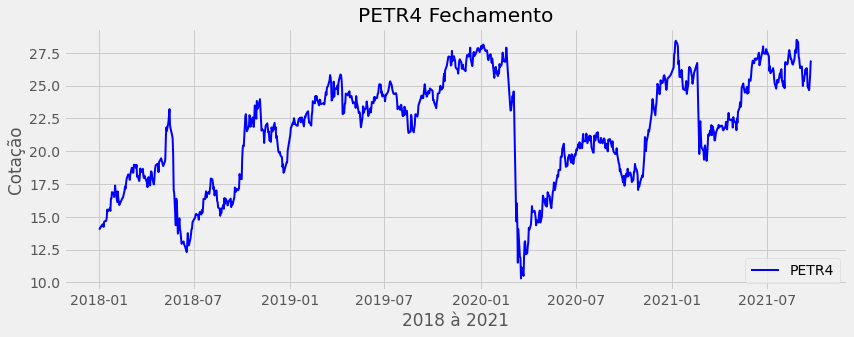

In [58]:
# Visualização

plt.figure(figsize=(12.5,4.5))
plt.plot(df["Adj Close"], label = "PETR4", linewidth = 2, color = "blue")
plt.title("PETR4 Fechamento")
plt.xlabel("2018 à 2021")
plt.ylabel("Cotação")
plt.legend(loc = "lower right")
plt.show()

In [59]:
# Cria as médias móveis

p1 = 10
p2 = 25

ma1 = pd.DataFrame()
ma1["Media_curta"] = df["Adj Close"].rolling(window = p1).mean()

ma2 = pd.DataFrame()
ma2["Media_longa"] = df["Adj Close"].rolling(window = p2).mean()

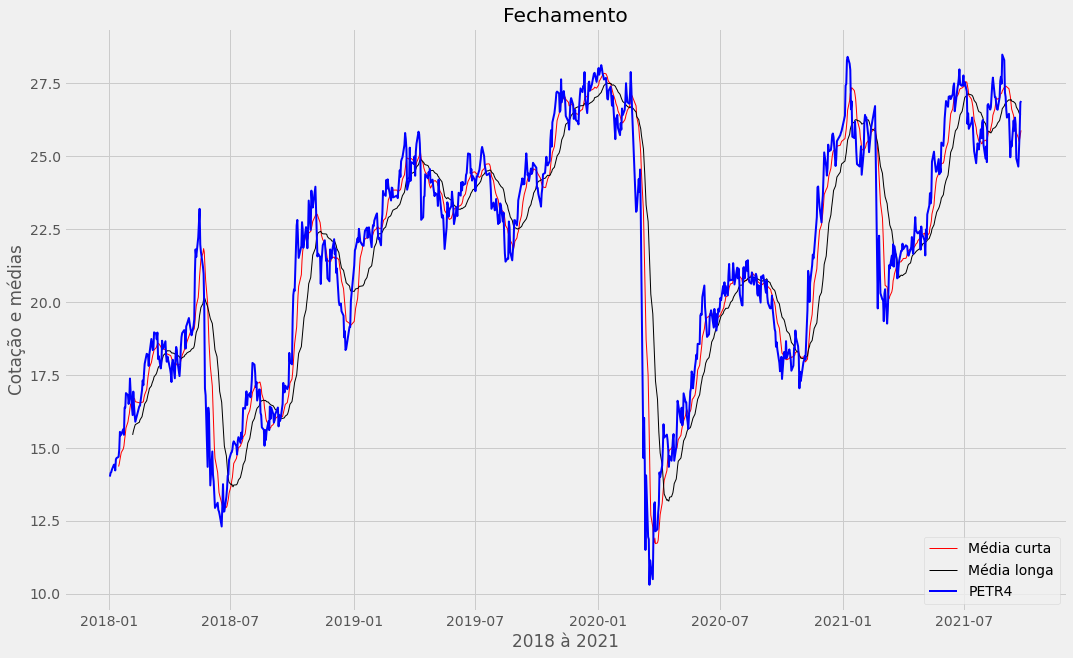

In [60]:
# Vizualiza todos os dados

plt.figure(figsize = (16, 10))
plt.plot(ma1["Media_curta"], label = "Média curta", linewidth = 1, color = "red")
plt.plot(ma2["Media_longa"], label = "Média longa", linewidth = 1, color = "black")
plt.plot(df["Adj Close"], label = "PETR4", linewidth = 2, color = "blue")
plt.title("Fechamento")
plt.xlabel("2018 à 2021")
plt.ylabel("Cotação e médias")
plt.legend(loc = "lower right")
plt.show()

In [61]:
# Criando um dataframe separado para criar a regra

df_regra = pd.DataFrame()
df_regra["Ativo"] = df["Adj Close"]
df_regra["Media_curta"] = ma1["Media_curta"]
df_regra["Media_longa"] = ma2["Media_longa"]
df_regra

,Ativo,Media_curta,Media_longa
Date,,,
2018-01-02,14.018620,NaN,NaN
2018-01-03,14.145677,NaN,NaN
2018-01-04,14.171090,NaN,NaN
2018-01-05,14.255794,NaN,NaN
2018-01-08,14.425202,NaN,NaN
...,...,...,...
2021-09-20,24.650000,25.639,26.570004
2021-09-21,25.209999,25.514,26.497200
2021-09-22,25.850000,25.602,26.450000


In [62]:
# Cria a regra do sinal
def regra(base):
    preco_compra = []
    preco_venda = []
    aux = 1
    
    for i in range(len(base)):
        if base["Media_curta"][i] > base["Media_longa"][i]:
            if aux != 1:
                preco_compra.append(base["Ativo"][i])
                preco_venda.append(np.nan)
                aux = 1
            else:
                preco_compra.append(np.nan)
                preco_venda.append(np.nan)
        elif base["Media_curta"][i] < base["Media_longa"][i]:
            if aux != 0:
                preco_compra.append(np.nan)
                preco_venda.append(base["Ativo"][i])
                aux = 0
            else:
                preco_compra.append(np.nan)
                preco_venda.append(np.nan)
        else:
            preco_compra.append(np.nan)
            preco_venda.append(np.nan)
    
    return (preco_compra, preco_venda)

In [63]:
# Armazena os valores
compra, venda = regra(df_regra)
sinal = pd.DataFrame()
sinal["Compra"] = compra
sinal["Venda"] = venda
df_regra["Compra"] = compra
df_regra["Venda"] = venda

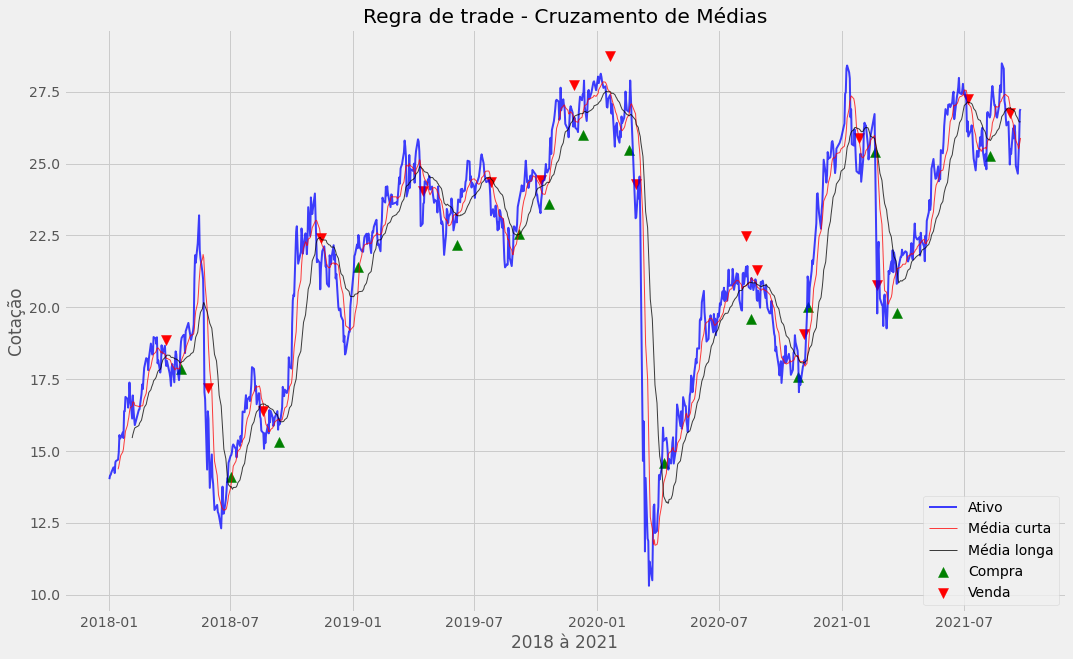

In [64]:
# Visualiza o cruzamento
plt.figure(figsize = (16, 10))
plt.plot(df_regra["Ativo"], label = "Ativo", alpha = 0.75, linewidth = 2, color = "blue")
plt.plot(df_regra["Media_curta"], label = "Média curta", alpha = 0.75, linewidth = 1, color = "red")
plt.plot(df_regra["Media_longa"], label = "Média longa", alpha = 0.75, linewidth = 1, color = "black")
plt.scatter(df_regra.index, df_regra["Compra"]*0.95, label = "Compra", marker = "^", s = 100, color = "green")
plt.scatter(df_regra.index, df_regra["Venda"]*1.05, label = "Venda", marker = "v", s = 100, color = "red")
plt.title("Regra de trade - Cruzamento de Médias")
plt.legend(loc = "lower right")
plt.xlabel("2018 à 2021")
plt.ylabel("Cotação")
plt.show()

In [65]:
df_compra = df_regra[ ~ df_regra["Compra"].isna()]
df_compra

,Ativo,Media_curta,Media_longa,Compra,Venda
Date,,,,,
2018-04-19,18.804430,18.087830,18.062758,18.804430,NaN
2018-07-03,14.852958,13.874362,13.763177,14.852958,NaN
2018-09-12,16.123861,16.120459,16.117060,16.123861,NaN
2019-01-09,22.515135,20.840058,20.524910,22.515135,NaN
2019-06-06,23.326399,23.225212,23.187728,23.326399,NaN
2019-09-06,23.724411,22.718896,22.540301,23.724411,NaN
2019-10-21,24.842644,24.369406,24.342032,24.842644,NaN
2019-12-11,27.376043,26.821318,26.754154,27.376043,NaN
2020-02-17,26.805408,26.693109,26.673936,26.805408,NaN


In [66]:
np.array(df_compra["Compra"])

array([18.80443001, 14.85295773, 16.12386131, 22.51513481, 23.32639885,
       23.72441101, 24.84264374, 27.37604332, 26.80540848, 15.35650158,
       20.63511848, 18.48943329, 21.07338715, 26.72521782, 20.83599281,
       26.60538483])

In [67]:
df_venda = df_regra[ ~ df_regra["Venda"].isna()]
df_venda

,Ativo,Media_curta,Media_longa,Compra,Venda
Date,,,,,
2018-03-28,17.957382,18.213194,18.313145,NaN,17.957382
2018-05-29,16.380693,19.342996,19.742219,NaN,16.380693
2018-08-20,15.621852,16.623188,16.639631,NaN,15.621852
2018-11-14,21.356672,22.298579,22.379411,NaN,21.356672
2019-04-15,22.912773,24.744557,24.811537,NaN,22.912773
2019-07-26,23.202133,24.323185,24.465380,NaN,23.202133
2019-10-08,23.277115,24.146654,24.187447,NaN,23.277115
2019-11-27,26.412479,26.579977,26.609289,NaN,26.412479
2020-01-20,27.389721,27.491062,27.501397,NaN,27.389721


In [68]:
np.array(df_venda["Venda"])

array([17.9573822 , 16.38069344, 15.62185192, 21.35667229, 22.91277313,
       23.20213318, 23.27711487, 26.4124794 , 27.38972092, 23.13518333,
       21.41121864, 20.28815651, 18.16073036, 24.65257645, 19.7859745 ,
       25.94473267, 25.5       ])

In [69]:
df_compra.shape

(16, 5)

In [70]:
df_venda.shape

(17, 5)

In [71]:
np.array(df_venda["Venda"])[:-1]

array([17.9573822 , 16.38069344, 15.62185192, 21.35667229, 22.91277313,
       23.20213318, 23.27711487, 26.4124794 , 27.38972092, 23.13518333,
       21.41121864, 20.28815651, 18.16073036, 24.65257645, 19.7859745 ,
       25.94473267])

In [72]:
np.array(df_venda["Venda"])[:-1]-np.array(df_compra["Compra"])

array([-0.84704781,  1.52773571, -0.50200939, -1.15846252, -0.41362572,
       -0.52227783, -1.56552887, -0.96356392,  0.58431244,  7.77868176,
        0.77610016,  1.79872322, -2.91265678, -2.07264137, -1.05001831,
       -0.66065216])

In [73]:
resultado = round(sum(np.array(df_venda["Venda"])[:-1]-np.array(df_compra["Compra"])), 2)

In [74]:
print("Resultado por ação: R$ " + str(resultado))

Resultado por ação: R$ -0.2
